In [18]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import RXGate, RZGate
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit import  execute, BasicAer
import qiskit.quantum_info as qi
import scipy.optimize 
import random
import matplotlib.pyplot as plt
import pickle
import os 
from sklearn.model_selection import train_test_split
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes
from sklearn.utils import shuffle
from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA,L_BFGS_B,ADAM
from IPython.display import clear_output
from qiskit import  execute, BasicAer
from qiskit.circuit import ParameterVector
from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

from scipy.special import rel_entr

In [19]:
binNumber=200


def computeFidelity(N,targets):
    #compute the fidelity distribution between N random targets:
    N_eff=min(targets.shape[0],N)
    
        
    index=np.random.choice(range(targets.shape[0]),N_eff,replace=False)
    matrices=targets[index]
    fidelity_all=[]
    for i in range(N_eff):
        for j in np.arange(i+1,N_eff):
      
            matrix=np.matmul(matrices[i],np.transpose(matrices[j].conjugate()))
            fidelity=(abs(matrix.flatten()[0]))**2 #absolute value square of the |0> state vev
            #fidelity=process_fidelity(matrices[i],matrices[j])
            fidelity_all.append(fidelity)
            
    return fidelity_all

def getHist(N_fidelity,matrices,bins):
    fidelity=computeFidelity(N_fidelity,matrices)
    weights = np.ones_like(fidelity)/float(len(fidelity))
    hist=np.histogram(fidelity, bins=bins, weights=weights, range=[0, 1])[0]
    return fidelity,hist,weights
    

#Possible Bin
bins_list=[];
for i in range(binNumber+1):
    bins_list.append((i)/binNumber)
#Center of the Bean
bins_x=[]    
for i in range(binNumber):
    bins_x.append(bins_list[1]+bins_list[i])
def P_harr(l,u,N):
    return (1-l)**(N-1)-(1-u)**(N-1)
    #Harr historgram

        

def Dot(data):
    output=[]
    
    for i in range(data.shape[0]):
        event=[]
        #first record dot product with itself:
        for j in range(data.shape[1]):
            event.append((data[i][j]*data[i][j]).sum())
            
        for j in range(data.shape[1]):
            for k in np.arange(j+1,data.shape[1]):
                event.append((data[i][j]*data[i][k]).sum())
        output.append(np.array(event))
    
    output=np.array(output)
    return output




In [20]:
def analyze(N_particles,N_dimension,model='baseline',n_samples=50):
    
    inputs=[]
    for d in range(N_particles):
        inputs.append(np.random.rand(N_dimension)*2*np.pi)
    
    if model=='baseline':
        inputs=np.array(inputs).flatten()
        estimator=getBaseline(inputs,num_layers=8)
    else:
        inputs=Dot(np.array([inputs]))[0]
        estimator=getRotPerm(inputs,num_layers=2)
        
    inputs=np.pi*2*inputs/inputs.max()
    inputs=np.zeros_like(inputs)

    
    grad_list=[]
    for i in range(n_samples):
        print(i)
        if i%10==0:
            print(i)
        weights=np.pi*2*np.random.rand(estimator.num_weights)
        grad=estimator.backward(inputs,weights=weights)[1][0][0]
        grad_list.append(grad)
    grad_list=np.array(grad_list)
    
    return grad_list

In [21]:

def getBaseline(inputs,num_layers=2):

    num_qubits = inputs.shape[0]

    n_params=num_layers*num_qubits

    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
    feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
    ansatz=RealAmplitudes(num_qubits, reps=num_layers)
    qc.compose(feature_map, inplace=True) 
    qc.compose(ansatz,inplace=True)    

    observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])

    estimator_qnn_baseline = EstimatorQNN(
        circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=ansatz.parameters
    )
    return estimator_qnn_baseline 


rotPerm

In [22]:

def getRotPerm(inputs,num_layers=2):
    num_layers=2
    num_qubits=inputs.shape[0]
    n_params=num_layers*4
    
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
    feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")


    weights = ParameterVector("weight", n_params)
    #print(f"weight parameters: {[str(item) for item in weights.params]}")

    inputParams_index=0
    params_index=0


    qc.compose(feature_map, inplace=True) 

    for layer in range(num_layers):

            for i in range(N_particles):
                qc.ry(weights[params_index],i)

            params_index += 1 

            for i in range(N_particles):
                for k in np.arange(i,N_particles,1):
                    if i!=k:
                        qc.rzz(weights[params_index],i,k)


            params_index += 1
            for j in np.arange(N_particles,num_qubits,1):
                qc.ry(weights[params_index],j)
            params_index += 1

            for i in np.arange(N_particles,num_qubits,1):
                for k in np.arange(i,num_qubits,1):
                    if i!=k:
                        qc.rzz(weights[params_index],i,k)

            params_index += 1


            qc.barrier()

    observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
    estimator_qnn_rotPerm = EstimatorQNN(
        circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=weights
    )
    
    return estimator_qnn_rotPerm



In [23]:
n_samples=100
N_particles_list=[3]
N_dimension_list=[2,3,4]

In [24]:
def getVar(arr,division=5):
    var_list=[]
    
    size=int(arr.shape[0]/5)
    for i in range(5):
        tmp=arr[i*size:(i+1)*size][:,0].var()
        var_list.append(tmp)
    var_list=np.array(var_list)
    
    return var_list.mean(),var_list.std()

In [8]:
# var_list_baseline=[]
# var_list_baseline_err=[]
# var_list_rotPerm=[]
# var_list_rotPerm_err=[]

# for N_particles in N_particles_list:
#     for N_dimension in N_dimension_list:
#         print(N_particles, " particles, ", N_dimension, " dimensions")
#         inputs=[]
#         for d in range(N_particles):
#             inputs.append(np.random.rand(N_dimension)*2*np.pi)

#         input_baseline=np.array(inputs).flatten()
#         input_dot=Dot(np.array([inputs]))[0]
        

#         estimator_qnn_baseline = getBaseline(input_baseline,num_layers=8)
#         grad_list_baseline=analyze(N_particles,N_dimension,model='baseline',n_samples=n_samples)
        
#         var_baseline,var_baseline_err=getVar(grad_list_baseline)
#         var_list_baseline.append(var_baseline)
#         var_list_baseline_err.append(var_baseline_err)

        
#         grad_list_rotPerm=analyze(N_particles,N_dimension,model='rotPerm',n_samples=n_samples)
#         var_rotPerm,var_rotPerm_err=getVar(grad_list_rotPerm)
#         var_list_rotPerm.append(var_rotPerm)
#         var_list_rotPerm_err.append(var_rotPerm_err)

    
        
#         clear_output(wait=True)

        


In [25]:

var_list_baseline = [0.01545637, 0.00165651, 0.00025767]
var_list_baseline_err = [3.26948779e-03, 3.00784991e-04, 9.15524995e-05]
var_list_rotPerm = [0.1252678,  0.07307157, 0.09645187]
var_list_rotPerm_err = [0.06516702, 0.03046665, 0.0209869 ]

var_list_baseline=np.array(var_list_baseline)
var_list_baseline_err=np.array(var_list_baseline_err)

var_list_rotPerm=np.array(var_list_rotPerm)
var_list_rotPerm_err=np.array(var_list_rotPerm_err)

print(var_list_baseline)
print(var_list_baseline_err)
print(var_list_rotPerm)
print(var_list_rotPerm_err)


[0.01545637 0.00165651 0.00025767]
[3.26948779e-03 3.00784991e-04 9.15524995e-05]
[0.1252678  0.07307157 0.09645187]
[0.06516702 0.03046665 0.0209869 ]


In [26]:
import seaborn as sns

<Figure size 432x288 with 0 Axes>

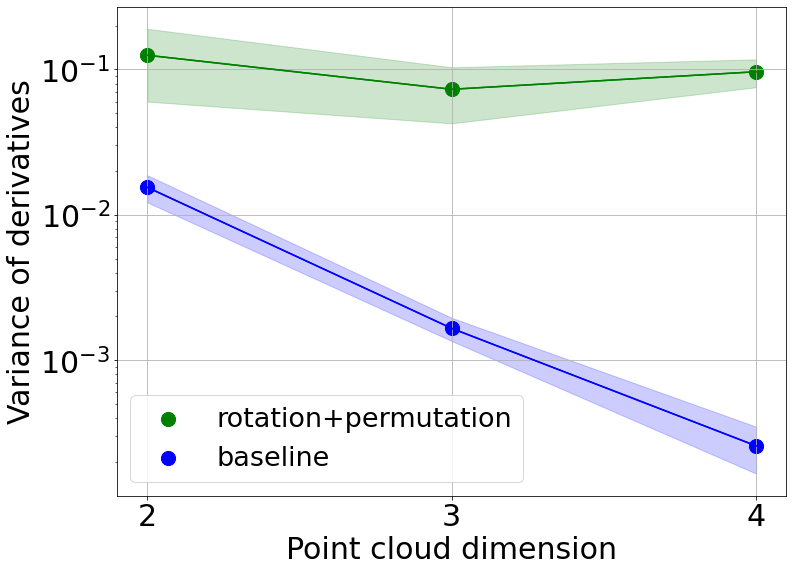

In [27]:
LabelSize=30
plt.figure(1)
plt.figure(figsize=(12,9))

#sns.set()
N = 100
x = np.arange(N)


plt.plot(N_dimension_list, var_list_baseline, 'b-')
plt.fill_between(N_dimension_list, var_list_baseline - var_list_baseline_err,var_list_baseline + var_list_baseline_err, color='b', alpha=0.2)
plt.plot(N_dimension_list, var_list_rotPerm, 'g-')
plt.fill_between(N_dimension_list, var_list_rotPerm - var_list_rotPerm_err,var_list_rotPerm+ var_list_rotPerm_err, color='g', alpha=0.2)


plt.plot(N_dimension_list,var_list_rotPerm,color='green')
plt.plot(N_dimension_list,var_list_baseline,color='blue')
plt.scatter(N_dimension_list,var_list_rotPerm,label='rotation+permutation',s=200,color='green')
plt.scatter(N_dimension_list,var_list_baseline,label='baseline',s=200,color='blue')
# plt.errorbar(N_dimension_list,var_list_rotPerm,yerr=var_list_rotPerm_err,ms=200,color='green',capsize=20)
# plt.errorbar(N_dimension_list,var_list_baseline,yerr=var_list_baseline_err,ms=200,color='blue',capsize=20)
plt.grid()
plt.yscale('log')
plt.xlabel('Point cloud dimension',fontsize=LabelSize)
plt.ylabel('Variance of derivatives',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.xticks(range(2,5))
plt.legend(fontsize=LabelSize*0.9)
plt.savefig("var_vs_dimension.png",bbox_inches='tight')

In [28]:
n_samples=100
N_particles_list=[3,4,5]
N_dimension_list=[2]

N_particles_list=np.array(N_particles_list)
N_dimension_list=np.array(N_dimension_list)

In [29]:
# var_list_baseline=[]
# var_list_baseline_err=[]
# var_list_rotPerm=[]
# var_list_rotPerm_err=[]

# for N_particles in N_particles_list:
#     for N_dimension in N_dimension_list:
#         print(N_particles, " particles, ", N_dimension, " dimensions")
#         inputs=[]
#         for d in range(N_particles):
#             inputs.append(np.random.rand(N_dimension)*2*np.pi)

#         input_baseline=np.array(inputs).flatten()
#         input_dot=Dot(np.array([inputs]))[0]
        

#         estimator_qnn_baseline = getBaseline(input_baseline,num_layers=8)
#         grad_list_baseline=analyze(N_particles,N_dimension,model='baseline',n_samples=n_samples)
        
#         var_baseline,var_baseline_err=getVar(grad_list_baseline)
#         var_list_baseline.append(var_baseline)
#         var_list_baseline_err.append(var_baseline_err)

        
#         grad_list_rotPerm=analyze(N_particles,N_dimension,model='rotPerm',n_samples=n_samples)
#         var_rotPerm,var_rotPerm_err=getVar(grad_list_rotPerm)
#         var_list_rotPerm.append(var_rotPerm)
#         var_list_rotPerm_err.append(var_rotPerm_err)

    
        
#         clear_output(wait=True)


In [30]:
var_list_baseline = [0.01433938, 0.00410675, 0.00095235]
var_list_baseline_err = [0.00564662, 0.00058109, 0.00023984]
var_list_rotPerm = [0.09596719, 0.07042314, 0.05007004]
var_list_rotPerm_err = [0.03995437, 0.04564635, 0.048503  ]


var_list_baseline=np.array(var_list_baseline)
var_list_baseline_err=np.array(var_list_baseline_err)

var_list_rotPerm=np.array(var_list_rotPerm)
var_list_rotPerm_err=np.array(var_list_rotPerm_err)

print(var_list_baseline)
print(var_list_baseline_err)
print(var_list_rotPerm)
print(var_list_rotPerm_err)


[0.01433938 0.00410675 0.00095235]
[0.00564662 0.00058109 0.00023984]
[0.09596719 0.07042314 0.05007004]
[0.03995437 0.04564635 0.048503  ]


<Figure size 432x288 with 0 Axes>

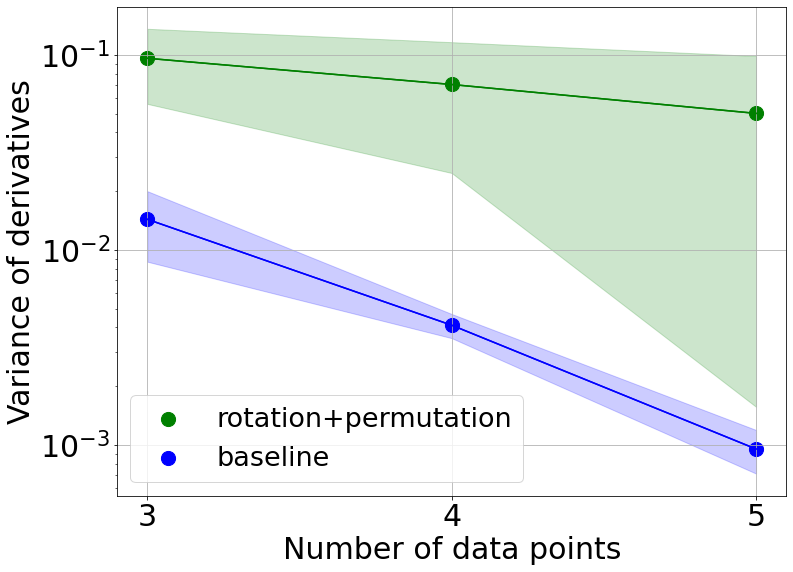

In [31]:
LabelSize=30
plt.figure(1)
plt.figure(figsize=(12,9))

#sns.set()
plt.plot(N_particles_list, var_list_baseline, 'b-')
plt.fill_between(N_particles_list, var_list_baseline - var_list_baseline_err,var_list_baseline + var_list_baseline_err, color='b', alpha=0.2)
plt.plot(N_particles_list, var_list_rotPerm, 'g-')
plt.fill_between(N_particles_list, var_list_rotPerm - var_list_rotPerm_err,var_list_rotPerm+ var_list_rotPerm_err, color='g', alpha=0.2)


plt.plot(N_particles_list,var_list_rotPerm,color='green')
plt.plot(N_particles_list,var_list_baseline,color='blue')
plt.scatter(N_particles_list,var_list_rotPerm,label='rotation+permutation',s=200,color='green')
plt.scatter(N_particles_list,var_list_baseline,label='baseline',s=200,color='blue')
plt.yscale('log')
plt.grid()
plt.xlabel('Number of data points',fontsize=LabelSize)
plt.ylabel('Variance of derivatives',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.xticks(range(3,6))
plt.legend(fontsize=LabelSize*0.9)
plt.savefig("var_vs_nParticles.png",bbox_inches='tight')

In [16]:
baseline_qubits=[6,8,9,10,12]
baseline_var=np.array([(0.01433938+0.01545637)/2,0.00410675, 0.00165651, 0.00095235,0.00025767])
baseline_err=np.array([0.0032624326749129662, 0.00058109 , 3.00784991e-04, 0.00023984, 9.15524995e-05])


rotPerm_qubits=[6,10,15]
rotPerm_var=np.array([0.053146940000000004,0.07042314, 0.05007004])
rotPerm_err=np.array([ 0.08492207552580072/4, 0.04564635, 0.048503 ])

<Figure size 432x288 with 0 Axes>

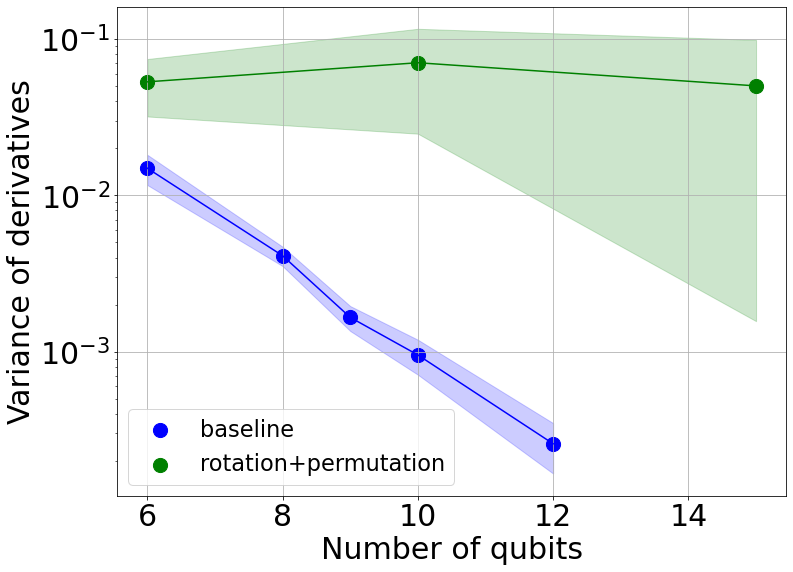

In [17]:
LabelSize=30
plt.figure(1)
plt.figure(figsize=(12,9))

#sns.set()
plt.plot(baseline_qubits, baseline_var, 'b-')
plt.fill_between(baseline_qubits, baseline_var - baseline_err,baseline_var + baseline_err, color='b', alpha=0.2)
plt.scatter(baseline_qubits, baseline_var,label='baseline',s=200,color='blue')

plt.plot(rotPerm_qubits, rotPerm_var, 'g-')
plt.fill_between(rotPerm_qubits, rotPerm_var - rotPerm_err,rotPerm_var + rotPerm_err, color='g', alpha=0.2)
plt.scatter(rotPerm_qubits, rotPerm_var,label='rotation+permutation',s=200,color='green')

# plt.plot(N_particles_list, var_list_rotPerm, 'g-')
# plt.fill_between(N_particles_list, var_list_rotPerm - var_list_rotPerm_err,var_list_rotPerm+ var_list_rotPerm_err, color='g', alpha=0.2)
# plt.plot(N_particles_list,var_list_rotPerm,color='green')
# plt.plot(N_particles_list,var_list_baseline,color='blue')
# plt.scatter(N_particles_list,var_list_rotPerm,label='rotation+permutation',s=200,color='green')
# plt.scatter(N_particles_list,var_list_baseline,label='baseline',s=200,color='blue')
plt.grid()
plt.yscale('log')
plt.xlabel('Number of qubits',fontsize=LabelSize)
plt.ylabel('Variance of derivatives',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
#plt.xticks(baseline_qubits)
plt.legend(fontsize=LabelSize*0.75)
plt.savefig("var_vs_nQubits.png",bbox_inches='tight')